# Report on CTM MILP Model Findings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughput as NoPhasingModel
from ctmmodels.delaythroughput import DelayThroughputAltPhasing as AltPhasingModel

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [33]:
model1 = AltPhasingModel(
    r_left=1.0/3.0,
    r_through=1.0/3.0,
    r_right=1.0/3.0,
    demand=450,
    sat_flow_rate=600,
    time_range=30,
    use_flow_weight=True,
    flow_weight=1
)

model2 = AltPhasingModel(
    r_left=1.0/3.0,
    r_through=1.0/3.0,
    r_right=1.0/3.0,
    demand=450,
    sat_flow_rate=600,
    time_range=30,
    use_flow_weight=False
)

In [34]:
model1.generate()
model2.generate()

In [35]:
model1.solve(log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2212 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 316 substitutions.
Reduced MIP has 3022 rows, 1672 columns, and 11472 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.79 ticks)
Found incumbent of value 1720.044950 after 0.04 sec. (31.26 ticks)
Probing fixed 0 vars, tightened 139 bounds.
Probing time = 0.00 sec. (0.59 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 560 rows and 104 columns.
Aggregator did 56 substitutions.
Reduced MIP has 2406 rows, 1512 columns, and 9884 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.07 ticks)
Probing time = 0.00 sec. (1.25 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8

4.295240163803101

In [36]:
model2.solve(log_output=True)

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 2212 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 316 substitutions.
Reduced MIP has 3022 rows, 1672 columns, and 11472 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (13.80 ticks)
Found incumbent of value 1720.044950 after 0.04 sec. (31.25 ticks)
Probing fixed 0 vars, tightened 139 bounds.
Probing time = 0.00 sec. (0.59 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 560 rows and 104 columns.
Aggregator did 56 substitutions.
Reduced MIP has 2406 rows, 1512 columns, and 9884 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (8.07 ticks)
Probing time = 0.00 sec. (1.25 ticks)
Clique table members: 120.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8

2.1159310340881348

In [37]:
dfx_noph, dfy_noph, dfg_noph = model1.return_solution()
dfx_altph, dfy_altph, dfg_altph = model2.return_solution()

### Findings

* Testing both no-phase models, one with a flow weight of 1 and another with a flow weight of 0, the former took 138s to solve, while the latter took 12s. However, the flows were a lot more stable.

* A flow weight of 0.2 seemed to go midway, taking only 6s to solve, and being more stable than with a flow weight of 0, but being less stable than with a flow weight of 1.

---

* Testing both alt-phase models on the same flow weights showed the same improvement, but not completely. The one with a flow weight of 1 still held back some flow. However, solve time was much shorter at 4s.

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Model parameters

In [7]:
print('Maximum finite capacity: \t{:.3f}'.format(model1.M[1,0,0]))
print('Maximum cell flow rate:  \t{:.3f}'.format(model1.F[0,0,0]))

Maximum finite capacity: 	22.278
Maximum cell flow rate:  	1.333


## Comparing cell volumes

### Between models

In [38]:
approach = 0

cell_path = [
    (CELL_SOURCE,0,approach),
    (CELL_NORMAL,0,approach),
    (CELL_NORMAL,1,approach),
    (CELL_NORMAL,2,approach),
    (CELL_MOVEMENT,THROUGH_TURN,approach),
    model1.S[(CELL_MOVEMENT,THROUGH_TURN,approach)][0]
]

In [39]:
dfx_noph_approach = pd.concat([
    dfx_noph[dfx_noph.cell == c].sort_values(by='timestep')
    for c in cell_path
]).pivot(index='timestep', columns='cell', values='volume')

dfx_altph_approach = pd.concat([
    dfx_altph[dfx_altph.cell == c].sort_values(by='timestep')
    for c in cell_path
]).pivot(index='timestep', columns='cell', values='volume')

Text(0,0.5,'Volume (instantaneous / cumulative)')

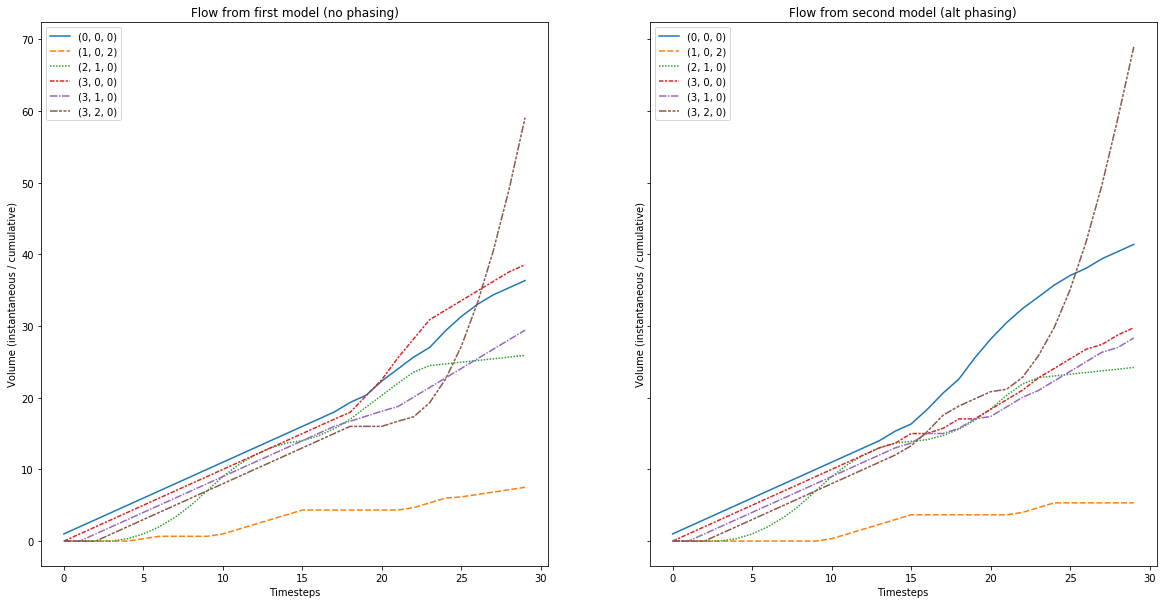

In [40]:
_, axs = plt.subplots(1,2, figsize=(20,10), sharey=True)

sns.lineplot(data=dfx_noph_approach.cumsum(), ax=axs[0])
sns.lineplot(data=dfx_altph_approach.cumsum(), ax=axs[1])

axs[0].set_title('Flow from first model (no phasing)')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Volume (instantaneous / cumulative)')

axs[1].set_title('Flow from second model (alt phasing)')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Volume (instantaneous / cumulative)')

## Comparing flows

### Between models

In [31]:
dfy_noph_approach = pd.concat([
    dfy_noph[dfy_noph.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
    for c in cell_path
]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')

dfy_altph_approach = pd.concat([
    dfy_altph[dfy_altph.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
    for c in cell_path
]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')

Text(0,0.5,'Flow (instantaneous / cumulative)')

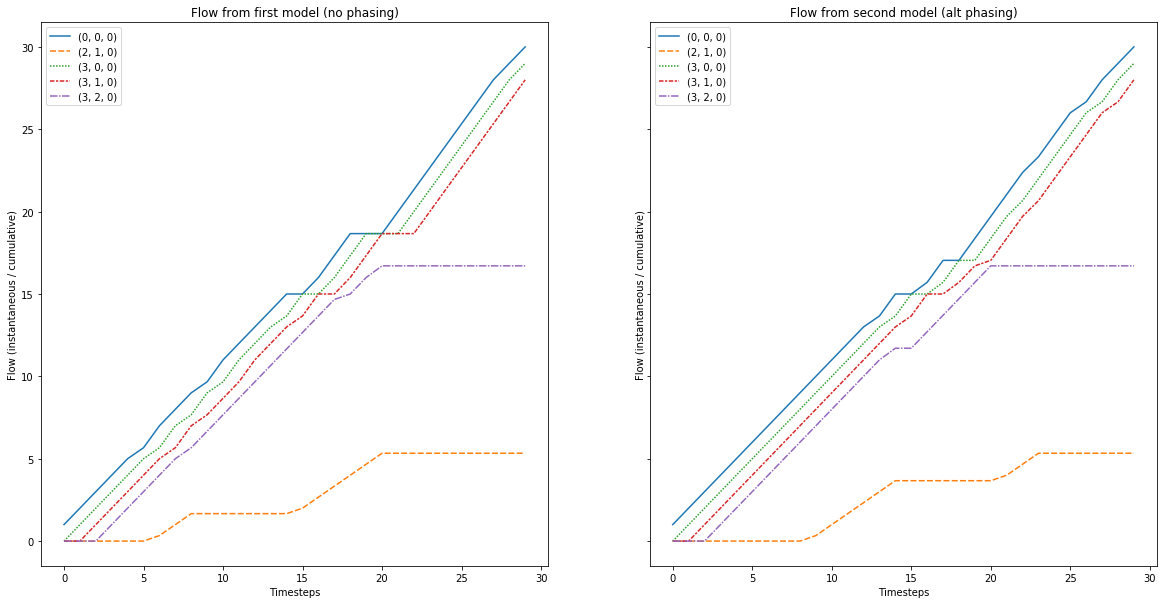

In [32]:
_, axs = plt.subplots(1,2, figsize=(20,10), sharey=True)

sns.lineplot(data=dfy_noph_approach.cumsum(), ax=axs[0])
sns.lineplot(data=dfy_altph_approach.cumsum(), ax=axs[1])

axs[0].set_title('Flow from first model (no phasing)')
axs[0].set_xlabel('Timesteps')
axs[0].set_ylabel('Flow (instantaneous / cumulative)')

axs[1].set_title('Flow from second model (alt phasing)')
axs[1].set_xlabel('Timesteps')
axs[1].set_ylabel('Flow (instantaneous / cumulative)')

## Comparing specific green time

### No phasing

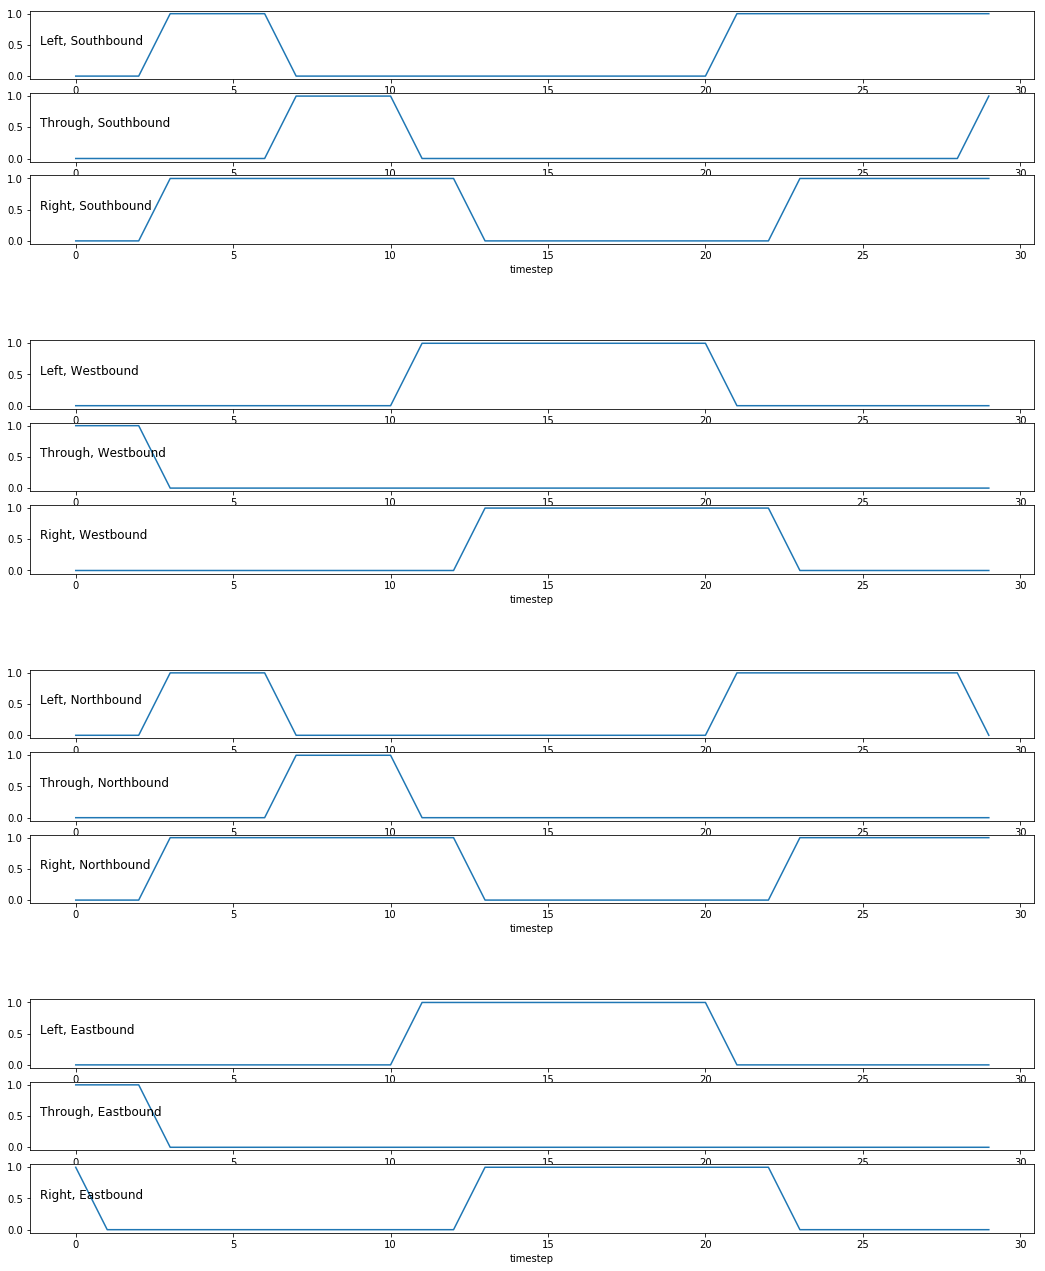

In [14]:
dfg_noph_map = dfg_noph.pivot(index='timestep', columns='cell', values='is_green')
movement_cells = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

_, axs = plt.subplots(16,1,figsize=(18,24), sharey=True)

approaches = [
    'Southbound',
    'Westbound',
    'Northbound',
    'Eastbound'
]

turns = [
    'Left',
    'Through',
    'Right',
]

for i in range(16):
    if i % 4 == 3:
        axs[i].set_visible(False)
        continue
    cell = movement_cells[i // 4][i % 4]
    sns.lineplot(data=dfg_noph_map[[cell]], ax=axs[i])
    axs[i].text(0.01, .5, '{}, {}'.format(turns[cell[1]], approaches[cell[2]]),
        horizontalalignment='left',
        transform=axs[i].transAxes,
        fontsize='large')
    axs[i].get_legend().remove()

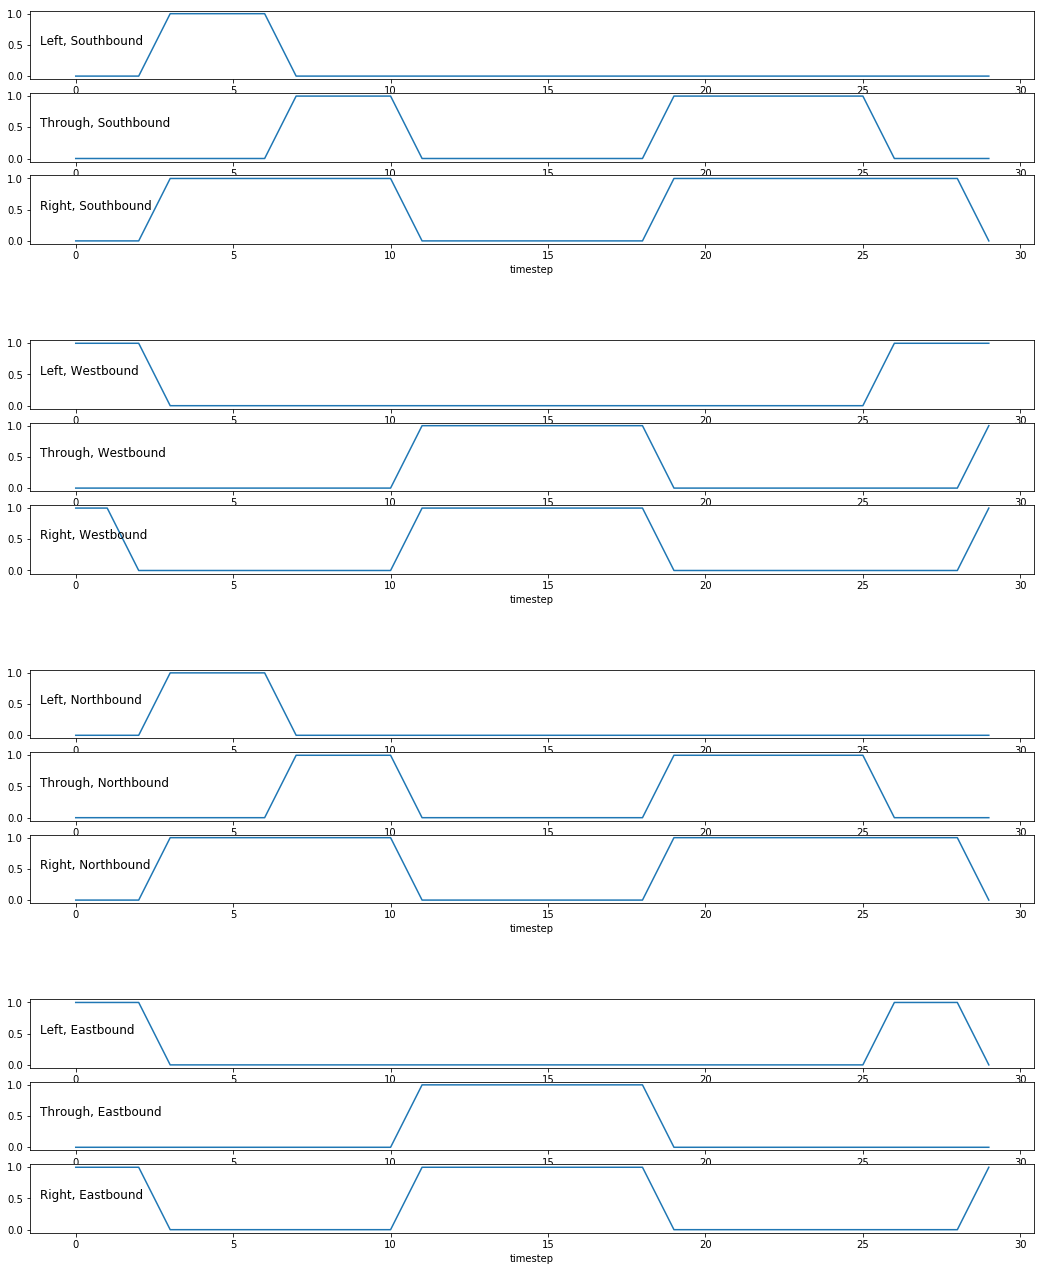

In [15]:
dfg_altph_map = dfg_altph.pivot(index='timestep', columns='cell', values='is_green')
movement_cells = [ [ (CELL_MOVEMENT,t,a) for t in range(3) ] for a in range(4) ]

_, axs = plt.subplots(16,1,figsize=(18,24), sharey=True)

approaches = [
    'Southbound',
    'Westbound',
    'Northbound',
    'Eastbound'
]

turns = [
    'Left',
    'Through',
    'Right',
]

for i in range(16):
    if i % 4 == 3:
        axs[i].set_visible(False)
        continue
    cell = movement_cells[i // 4][i % 4]
    sns.lineplot(data=dfg_altph_map[[cell]], ax=axs[i])
    axs[i].text(0.01, .5, '{}, {}'.format(turns[cell[1]], approaches[cell[2]]),
        horizontalalignment='left',
        transform=axs[i].transAxes,
        fontsize='large')
    axs[i].get_legend().remove()

### Alternative phasing

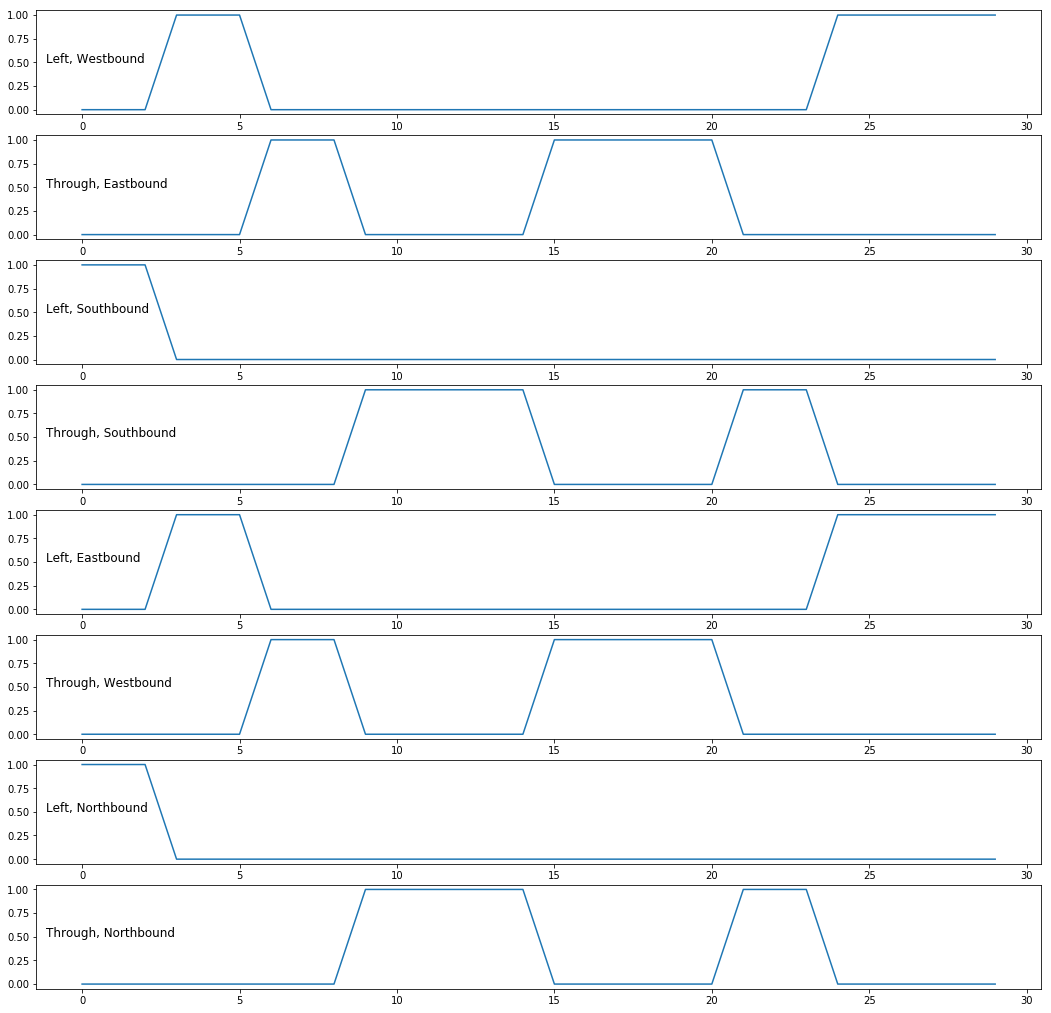

In [29]:
dfg_altph_map = dfg_altph.pivot(index='timestep', columns='cell', values='is_green')
throughs = [intToBinTuple(x) for x in [1,3,5,7]]
lefts = [intToBinTuple(x) for x in [0,2,4,6]]

all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

_, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

for ndx, t in enumerate(all_phases):
    sns.lineplot(data=dfg_altph_map[t], ax=axs[ndx])
    axs[ndx].text(0.01,.5,all_phases_labels[ndx],
        horizontalalignment='left',
        transform=axs[ndx].transAxes,
        fontsize='large')